In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy scikit-learn pywavelets tensorflow autokeras

In [2]:
import sys
!{sys.executable} -m pip install numpy pandas scikit-learn xgboost statsmodels matplotlib

2025-07-15 14:06:41,664 [INFO] Loading CSV: C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\MRG_4_White_River_1month_3month_time_engineered.csv
2025-07-15 14:06:41,712 [INFO] Loaded 129 rows
2025-07-15 14:06:41,874 [INFO] Binary threshold fixed at 25th percentile: 631.33 ft
2025-07-15 14:06:41,875 [INFO] Bootstrapping Gradient Boosting (50 runs)...
2025-07-15 14:06:43,911 [INFO] [Gradient Boosting] Boot 10/50 complete
2025-07-15 14:06:45,913 [INFO] [Gradient Boosting] Boot 20/50 complete
2025-07-15 14:06:47,937 [INFO] [Gradient Boosting] Boot 30/50 complete
2025-07-15 14:06:49,938 [INFO] [Gradient Boosting] Boot 40/50 complete
2025-07-15 14:06:51,911 [INFO] [Gradient Boosting] Boot 50/50 complete
2025-07-15 14:06:51,911 [INFO] Bootstrapping XGBoost (50 runs)...
2025-07-15 14:06:52,887 [INFO] [XGBoost] Boot 10/50 complete
2025-07-15 14:06:53,798 [INFO] [XGBoost] Boot 20/50 complete
2025-07-15 14:06:54,577 [INFO] [XGBoost] Boot 30/50 complete
2025-07-15 14:06:55,372 [INFO] [XGBoost] Bo


—GB Regression—
 R²: 0.823
 RMSE: 0.857
 MAE: 0.659
 Skill Score: 57.89%

—GB Binary (<631.33 ft)—
 Confusion Matrix: TN=25, FP=3, FN=0, TP=4
 Accuracy: 0.906
 Precision: 0.571
 Recall: 1.000
 F1 Score: 0.727
 POD: 1.000, POFD: 0.107, Bias: 1.750, PSS: 0.893

—XGBoost Regression—
 R²: 0.741
 RMSE: 1.036
 MAE: 0.750
 Skill Score: 49.07%

—XGBoost Binary (<631.33 ft)—
 Confusion Matrix: TN=25, FP=3, FN=0, TP=4
 Accuracy: 0.906
 Precision: 0.571
 Recall: 1.000
 F1 Score: 0.727
 POD: 1.000, POFD: 0.107, Bias: 1.750, PSS: 0.893

—SVR Regression—
 R²: 0.792
 RMSE: 0.928
 MAE: 0.700
 Skill Score: 54.41%

—SVR Binary (<631.33 ft)—
 Confusion Matrix: TN=26, FP=2, FN=1, TP=3
 Accuracy: 0.906
 Precision: 0.600
 Recall: 0.750
 F1 Score: 0.667
 POD: 0.750, POFD: 0.071, Bias: 1.250, PSS: 0.679


2025-07-15 14:06:57,829 [INFO] Time-series plot saved to: C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\MG4_ML_PLOTS\TimeSeries_GWL_Uncertainty_With_PICP_PIW.png


,R²,RMSE,MAE,Skill Score (%),Mean Std Dev,PIW_95,PICP_95
Model,,,,,,,
GB,0.822675,0.856717,0.658961,57.889995,0.557489,1.940503,0.7500
XGBoost,0.740593,1.036199,0.749638,49.067964,0.708375,2.436277,0.7500
SVR,0.792150,0.927529,0.700498,54.409402,0.301549,1.136084,0.4375


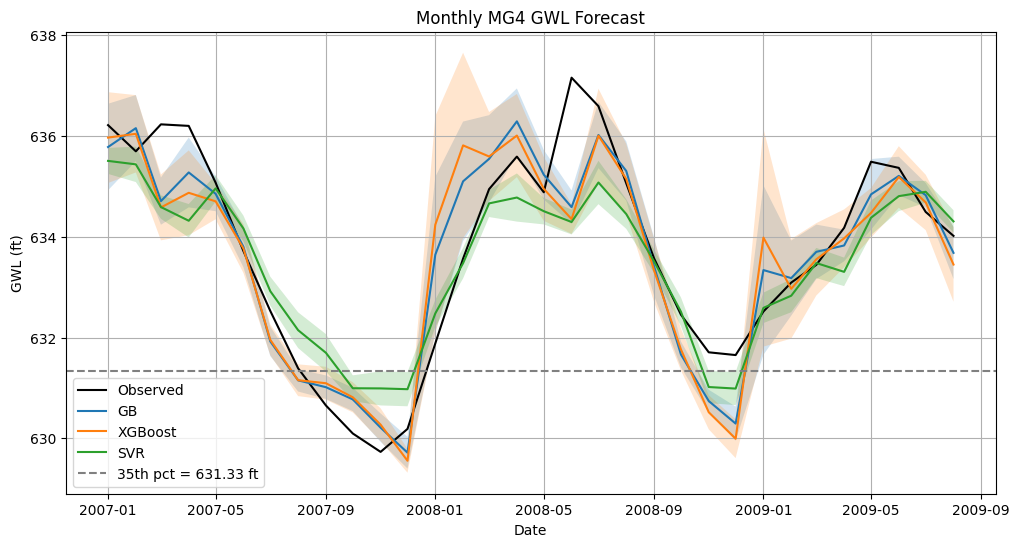

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score
)

# Logging Setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logger = logging.getLogger(__name__)

# Input and output paths
input_csv = r"C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\MRG_4_White_River_1month_3month_time_engineered.csv"
plots_dir = Path(r"C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\MG4_ML_PLOTS")
plots_dir.mkdir(parents=True, exist_ok=True)

#Input feature for the ML models to forecast the target variable
features = ['discharge_cfs_monthly', 'PRCP_monthly', 'pumpage_mgd_monthly']
target = 'gw_elev_monthly'

# ML model hyperpramaters
window = 3 # uses three prior months to inform next month's prediction
train_ratio = 0.75 # Uses a 75% train 25% test split 
n_boot = 50 # Bootstrapping; generates 50 predicitons per timestep to calculate ML model uncertainty 

# Load & scale data for ML models
logger.info("Loading CSV: %s", input_csv)
df = pd.read_csv(input_csv, parse_dates=['date']).set_index('date').sort_index().dropna()
logger.info("Loaded %d rows", len(df))

Xw, y = [], []
for i in range(window, len(df)):
    Xw.append(df[features].iloc[i-window:i].values)
    y.append(df[target].iloc[i])
X = np.array(Xw)
y = np.array(y)
dates = df.index[window:]

n_samples = len(y)
n_train = int(n_samples * train_ratio)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]
dates_test = dates[n_train:]

flat_dim = window * len(features)
Xtr = X_train.reshape((n_train, flat_dim))
Xte = X_test.reshape((len(y_test), flat_dim))

scaler = MinMaxScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# Defines a threshold to be used in the binary forecast
THRESHOLD = np.percentile(y_train, 25)
logger.info("Binary threshold fixed at 25th percentile: %.2f ft", THRESHOLD)

# Bootstrapping function
def bootstrap_predict(model_class, X_train, y_train, X_test, n_runs, model_name="", **kwargs):
    logger.info("Bootstrapping %s (%d runs)...", model_name, n_runs)
    preds = []
    for i in range(n_runs):
        boot_idx = np.random.choice(len(X_train), len(X_train), replace=True)
        model = model_class(**kwargs)
        model.fit(X_train[boot_idx], y_train[boot_idx])
        pred = model.predict(X_test)
        preds.append(pred)
        if (i + 1) % 10 == 0 or i == n_runs - 1:
            logger.info("[%s] Boot %d/%d complete", model_name, i + 1, n_runs)
    return np.array(preds)

# Run Bootstrapped ML Models
results = {}

results['GB'] = bootstrap_predict(
    GradientBoostingRegressor, Xtr_s, y_train, Xte_s, n_boot,
    model_name="Gradient Boosting", n_estimators=100
)

results['XGBoost'] = bootstrap_predict(
    XGBRegressor, Xtr_s, y_train, Xte_s, n_boot,
    model_name="XGBoost", n_estimators=100, verbosity=0
)

results['SVR'] = bootstrap_predict(
    SVR, Xtr_s, y_train, Xte_s, n_boot,
    model_name="SVR", kernel='rbf'
)

# Evaluation functions
def skill_score(y_t, y_p):
    rm = np.sqrt(mean_squared_error(y_t, y_p))
    rb = np.sqrt(np.mean((y_t - y_t.mean())**2))
    return 100 * (1 - rm/rb)

def eval_reg(y_t, y_p, name):
    r2   = r2_score(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    mae  = mean_absolute_error(y_t, y_p)
    ss   = skill_score(y_t, y_p)
    print(f"\n—{name} Regression—")
    print(f" R²: {r2:.3f}")
    print(f" RMSE: {rmse:.3f}")
    print(f" MAE: {mae:.3f}")
    print(f" Skill Score: {ss:.2f}%")

def eval_bin(y_t, y_p, name):
    yt = (y_t < THRESHOLD).astype(int)
    yp = (y_p < THRESHOLD).astype(int)
    cm = confusion_matrix(yt, yp)
    TN, FP, FN, TP = cm.ravel()
    acc  = accuracy_score(yt, yp)
    prec = precision_score(yt, yp, zero_division=0)
    rec  = recall_score(yt, yp, zero_division=0)
    f1   = f1_score(yt, yp, zero_division=0)
    POD  = TP/(TP+FN) if TP+FN>0 else 0
    POFD = FP/(FP+TN) if FP+TN>0 else 0
    bias = (TP+FP)/(TP+FN) if TP+FN>0 else np.nan
    pss  = (TP*TN - FP*FN)/((TP+FN)*(FP+TN)) if (TP+FN)*(FP+TN)>0 else np.nan
    print(f"\n—{name} Binary (<{THRESHOLD:.2f} ft)—")
    print(f" Confusion Matrix: TN={TN}, FP={FP}, FN={FN}, TP={TP}")
    print(f" Accuracy: {acc:.3f}")
    print(f" Precision: {prec:.3f}")
    print(f" Recall: {rec:.3f}")
    print(f" F1 Score: {f1:.3f}")
    print(f" POD: {POD:.3f}, POFD: {POFD:.3f}, Bias: {bias:.3f}, PSS: {pss:.3f}")

# Run Evaluations & Uncertainty Metrics
metrics_all = []
for name, preds in results.items():
    logger.info("Evaluating model: %s", name)
    mean_pred = preds.mean(axis=0)
    std_pred  = preds.std(axis=0)

    # Interval metrics
    lower = np.percentile(preds, 2.5, axis=0)
    upper = np.percentile(preds, 97.5, axis=0)
    piw = np.mean(upper - lower)  # Prediction Interval Width
    picp = np.mean((y_test >= lower) & (y_test <= upper))  # Coverage Probability

    # Regression Metrics
    r2   = r2_score(y_test, mean_pred)
    rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
    mae  = mean_absolute_error(y_test, mean_pred)
    ss   = skill_score(y_test, mean_pred)

    metrics_all.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Skill Score (%)': ss,
        'Mean Std Dev': np.mean(std_pred),
        'PIW_95': piw,
        'PICP_95': picp
    })

    # Print full metrics
    eval_reg(y_test, mean_pred, name)
    eval_bin(y_test, mean_pred, name)

metrics_df = pd.DataFrame(metrics_all).set_index("Model")

# Time Series Plot with Uncertainty
logger.info("Generating time series plot with uncertainty bands...")
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Observed', color='black')

for name, preds in results.items():
    mean_pred = preds.mean(axis=0)
    std_pred  = preds.std(axis=0)
    plt.plot(dates_test, mean_pred, label=name)
    plt.fill_between(dates_test, mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

plt.axhline(THRESHOLD, linestyle='--', color='gray', label=f'35th pct = {THRESHOLD:.2f} ft')
plt.title("Monthly MG4 GWL Forecast")
plt.xlabel("Date")
plt.ylabel("GWL (ft)")
plt.grid(True)
plt.legend()
ts_path = plots_dir / "TimeSeries_GWL_Uncertainty_With_PICP_PIW.png"
plt.savefig(ts_path, dpi=300)
logger.info("Time-series plot saved to: %s", ts_path)

# Display Final Metrics
from IPython.display import display
display(metrics_df)